In [31]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl")
from travel import init_travel
init_travel()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load preds

In [5]:
import json

RESULTS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug250/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug250_llava-1.5-7b-hf_beam8-4_coherence_20240813123904/outputs_val.json"
METRICS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug250/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug250_llava-1.5-7b-hf_beam8-4_coherence_20240813123904/metrics_coherence_nli_val.json"
preds = json.load(open(RESULTS_PATH, "r"))
coherence_metrics = json.load(open(METRICS_PATH, "r"))

# Look at cases with low relevance high informativeness

In [18]:
low_rel_low_info = []
low_rel_high_info = []
high_rel_low_info = []
high_rel_high_info = []

for output in preds.values():
    for question_idx in range(output['final_turn'] + 1):
        question = output['questions'][question_idx]
        answer = output['answers'][question_idx]
        selected_candidate_idx = output['candidate_questions'][question_idx].index(question)
        relevance = output['candidate_questions_scores'][question_idx][selected_candidate_idx]['relevance']
        informativeness = output['candidate_questions_scores'][question_idx][selected_candidate_idx]['informativeness_marginal']
        
        if relevance <= 0.2 and informativeness <= 0.2:
            low_rel_low_info.append((output['procedure'], question, answer))
        elif relevance <= 0.2 and informativeness >= 0.9:
            low_rel_high_info.append((output['procedure'], question, answer))
        elif relevance >= 0.9 and informativeness <= 0.2:
            high_rel_low_info.append((output['procedure'], question, answer))
        elif relevance >= 0.9 and informativeness >= 0.9:
            high_rel_high_info.append((output['procedure'], question, answer))
        
    

In [19]:
from travel.data.vqa import VQAResponse

from pprint import pprint

for procedure, question, answer in low_rel_high_info:
    print(f"{procedure} -> {question} {VQAResponse(answer).name}")

Sew the shoe with the thread and the awl in your hands -> Is the shoe in the process of being sewn? Yes
Insert the awl into the sandal -> Is the person holding the awl? Yes
Pull the thread -> Is the person holding the thread? Yes
Pull the thread -> Is the person's hand holding the thread? Yes
Clean the clay box with sand -> Is the person working on the procedure "Clean the clay box with sand"? Yes
Pick brush -> Is the person's hand holding the brush? Yes
Drop the towel on the chair -> Is the towel on the floor? No
Close the pack of sauce -> Is the pack of sauce sitting on the table? Yes
Cut a leaf with a scissor -> Are the scissors open or closed? Yes
Place the wood piece on a wall -> Is the person holding the wood piece? Yes
Remove the piece of wood from the wood cutting machine -> Is the piece of wood on the ground? Yes
Drop the bucket on the table -> Is the bucket on the ground? No
Remove the cut piece of wood from the cutting machine -> Is there a cutting machine in the image? Yes


In [14]:
from travel.data.vqa import VQAResponse

from pprint import pprint

for procedure, question, answer in high_rel_low_info:
    print(f"{procedure} -> {question} {VQAResponse(answer).name}")

In [24]:
from scipy.stats import entropy

print(entropy([0.5, 0.5], [0.4, 0.6]))


def relative_entropy(binary_prob0, binary_prob1):
    p0a = binary_prob0
    p0b = 1.0 - binary_prob0
    
    p1a = binary_prob1
    p1b = 1.0 - binary_prob1
    
    ent = np.log2(p0a/p1a)

0.020410997260127586


# Look at how max number of iterations impacts accuracy

In [36]:
from collections import defaultdict
import numpy as np

n_turns = []
success_probs_by_turn = defaultdict(list)
for output in preds.values():
    n_turns.append(output['final_turn'] + 1)
    for question_idx in range(10):
        this_question_idx = min(output['final_turn'], question_idx)
        
        question = output['questions'][this_question_idx]
        answer = output['answers'][this_question_idx]
        selected_candidate_idx = output['candidate_questions'][this_question_idx].index(question)
        relevance = output['candidate_questions_scores'][this_question_idx][selected_candidate_idx]['relevance']
        informativeness = output['candidate_questions_scores'][this_question_idx][selected_candidate_idx]['informativeness_marginal']
        
        success_prob = output['success_probs'][this_question_idx]
        success_probs_by_turn[question_idx].append(success_prob)
        
print("Average number of turns:", np.mean(n_turns))
print("Number of probs per turn:", [len(success_probs_by_turn[question_idx]) for question_idx in success_probs_by_turn])


Average number of turns: 3.828
Number of probs per turn: [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


In [37]:
from pprint import pprint

from travel.model.mistake_detection import MISTAKE_DETECTION_THRESHOLDS
from travel.model.metrics import mistake_detection_metrics

all_labels_binary = [output['mistake'] for output in preds.values()]

accuracy_metrics_by_question_idx = []
for question_idx in success_probs_by_turn:
    all_probs = success_probs_by_turn[question_idx]
    
    # Calculate accuracy metrics
    best_metrics = None
    best_threshold = None
    accuracy_metrics_by_threshold = {}
    coherence_metrics_by_threshold = {}
    for threshold in MISTAKE_DETECTION_THRESHOLDS:
        threshold_preds = [1.0 - p >= threshold for p in all_probs] # Have to do 1.0 - probability since we got "success" probability from VLM
        assert len(threshold_preds) == len(all_probs) == len(all_labels), "Expected same number of preds, probs, and labels."
        this_metrics = mistake_detection_metrics(all_labels_binary, threshold_preds)
        accuracy_metrics_by_threshold[threshold] = this_metrics

        if best_metrics is None or (this_metrics['false_positive_rate'] + this_metrics['false_negative_rate']) < (best_metrics['false_positive_rate'] + best_metrics['false_negative_rate']):
            best_metrics = this_metrics
            best_threshold = threshold

    accuracy_metrics_by_threshold['best_metrics'] = best_metrics
    accuracy_metrics_by_threshold['best_threshold'] = best_threshold
    
    accuracy_metrics_by_question_idx.append(accuracy_metrics_by_threshold)


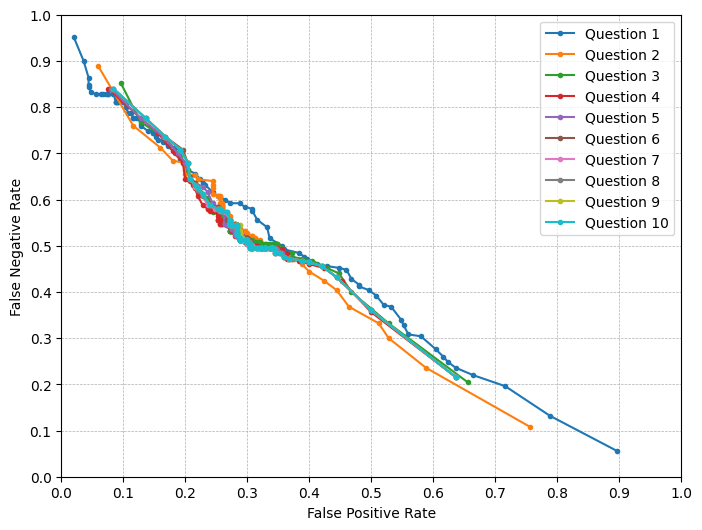

In [38]:
from travel.model.metrics import generate_det_curves

generate_det_curves(accuracy_metrics_by_question_idx, curve_names=[f"Question {question_idx+1}" for question_idx in range(len(accuracy_metrics_by_question_idx))], save_paths=[])

# Analysis on disagreements between VLM coherence metrics vs. NLI coherence metrics (8/14/2024)

In [32]:
from collections import defaultdict
from tqdm import tqdm

from travel.model.metrics import question_coherence_metrics_vlm

new_outputs = []
for example_id, output in tqdm(list(preds.items())):
    output = {'example_id': example_id} | output
    
    coherence_metrics_nli = defaultdict(list)

    vlm_metrics = question_coherence_metrics_vlm([output['success_probs']], [output['success_probs_negated']])
    coherence_metrics_vlm = {}
    coherence_metrics_vlm['relevance_marginal'] = vlm_metrics['relevance_marginal']
    coherence_metrics_vlm['informativeness_marginal'] = vlm_metrics['informativeness_marginal']
    coherence_metrics_vlm['informativeness_marginal_x_relevance_marginal'] = vlm_metrics['informativeness_marginal_x_relevance_marginal']
    
    for question_idx in range(output['final_turn'] + 1):
        
        question = output['questions'][question_idx]
        answer = output['answers'][question_idx]
        selected_candidate_idx = output['candidate_questions'][question_idx].index(question)
        relevance = output['candidate_questions_scores'][question_idx][selected_candidate_idx]['relevance_marginal']
        informativeness = output['candidate_questions_scores'][question_idx][selected_candidate_idx]['informativeness_marginal']
        informativeness_x_relevance = informativeness * relevance
        
        coherence_metrics_nli['relevance_marginal'].append(relevance)
        coherence_metrics_nli['informativeness_marginal'].append(informativeness)
        coherence_metrics_nli['informativeness_marginal_x_relevance_marginal'].append(informativeness_x_relevance)
        
        output['coherence_nli'] = coherence_metrics_nli
        output['coherence_vlm'] = coherence_metrics_vlm
        
        
    new_outputs.append(output)

100%|██████████| 500/500 [00:00<00:00, 3922.13it/s]


In [53]:
import matplotlib.pyplot as plt
import os
from PIL import Image
from pprint import pprint
import random

random_outputs_to_visualize = random.sample(new_outputs, 20)

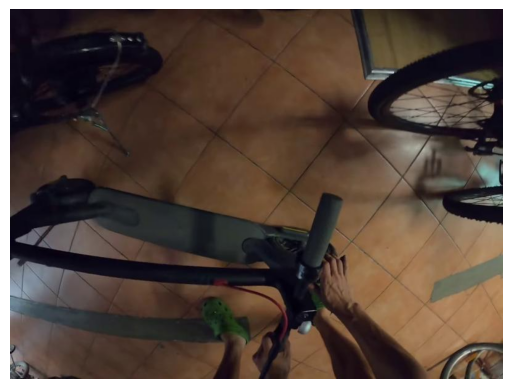

Procedure: Push the scooter with your hand (success: None)
Q1: Is the person pushing the scooter with their hand?
A1: Yes (0.808067)
Success probability 1: 0.962391

Coherence Metrics:
	Marginal Relevance (NLI): 0.946
	Marginal Relevance (VLM): 0.871009

	Marginal Informativeness (NLI): 0.824
	Marginal Informativeness (VLM): 0.76878

	Marginal Relevance x Marginal Informativeness (NLI): 0.7795039999999999
	Marginal Relevance x Marginal Informativeness (VLM): 0.669614


Q2: Is the person's hand on the scooter?
A2: Yes (0.982557)
Success probability 2: 0.985271

Coherence Metrics:
	Marginal Relevance (NLI): 0.43
	Marginal Relevance (VLM): 0.710141

	Marginal Informativeness (NLI): 0.417
	Marginal Informativeness (VLM): 0.889279

	Marginal Relevance x Marginal Informativeness (NLI): 0.17931
	Marginal Relevance x Marginal Informativeness (VLM): 0.631513


Q3: Is the person's hand pushing the scooter?
A3: Yes (0.986777)
Success probability 3: 0.992654

Coherence Metrics:
	Marginal Relevance

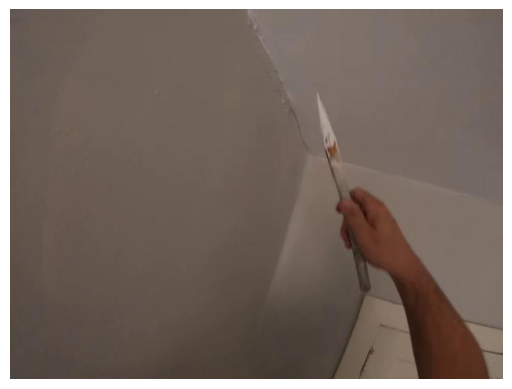

Procedure: Paint the watercolor on the stone with a paint brush (mistake: MisalignSRL_ARG1)
Q1: Is the watercolor on the stone?
A1: Yes (0.824462)
Success probability 1: 0.97631

Coherence Metrics:
	Marginal Relevance (NLI): 0.982
	Marginal Relevance (VLM): 0.957763

	Marginal Informativeness (NLI): 0.932
	Marginal Informativeness (VLM): 0.838315

	Marginal Relevance x Marginal Informativeness (NLI): 0.915224
	Marginal Relevance x Marginal Informativeness (VLM): 0.802907


Q2: Is the person using a paint brush to paint the watercolor on the stone?
A2: Yes (0.979036)
Success probability 2: 0.991015

Coherence Metrics:
	Marginal Relevance (NLI): 0.901
	Marginal Relevance (VLM): 0.866802

	Marginal Informativeness (NLI): 0.761
	Marginal Informativeness (VLM): 0.926013

	Marginal Relevance x Marginal Informativeness (NLI): 0.6856610000000001
	Marginal Relevance x Marginal Informativeness (VLM): 0.80267


Q3: Is the paint brush being used to paint the watercolor on the stone?
A3: Yes (0.998

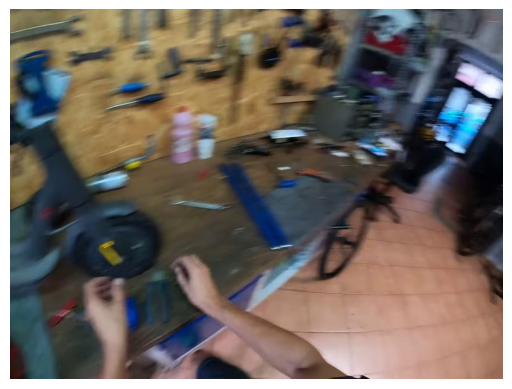

Procedure: Remove the tyre from a wheel turning stand (mistake: MisalignSRL_ARG1)
Q1: Is the tire on the stand?
A1: No (0.531209)
Success probability 1: 0.151028

Coherence Metrics:
	Marginal Relevance (NLI): 0.528
	Marginal Relevance (VLM): 0.570715

	Marginal Informativeness (NLI): 0.216
	Marginal Informativeness (VLM): 0.387593

	Marginal Relevance x Marginal Informativeness (NLI): 0.11404800000000001
	Marginal Relevance x Marginal Informativeness (VLM): 0.221205


Q2: Is the tire off the stand?
A2: Yes (0.795658)
Success probability 2: 0.810479

Coherence Metrics:
	Marginal Relevance (NLI): 0.561
	Marginal Relevance (VLM): 0.776889

	Marginal Informativeness (NLI): 0.258
	Marginal Informativeness (VLM): 0.299532

	Marginal Relevance x Marginal Informativeness (NLI): 0.144738
	Marginal Relevance x Marginal Informativeness (VLM): 0.232703


Q3: Is the tire on the floor?
A3: Yes (0.91118)
Success probability 3: 0.850965

Coherence Metrics:
	Marginal Relevance (NLI): 0.078
	Marginal Re

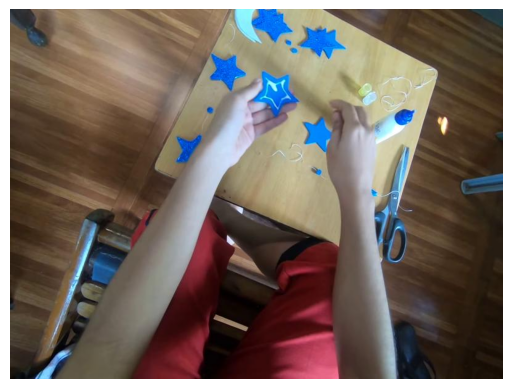

Procedure: Cut the paper with a scissors (mistake: MisalignSRL_V)
Q1: Is the person holding a pair of scissors?
A1: Yes (0.924142)
Success probability 1: 0.795658

Coherence Metrics:
	Marginal Relevance (NLI): 0.59
	Marginal Relevance (VLM): 0.705565

	Marginal Informativeness (NLI): 0.481
	Marginal Informativeness (VLM): 0.269472

	Marginal Relevance x Marginal Informativeness (NLI): 0.28379
	Marginal Relevance x Marginal Informativeness (VLM): 0.19013


Q2: Is the person cutting the paper with the scissors?
A2: Yes (0.973645)
Success probability 2: 0.979668

Coherence Metrics:
	Marginal Relevance (NLI): 0.938
	Marginal Relevance (VLM): 0.947078

	Marginal Informativeness (NLI): 0.805
	Marginal Informativeness (VLM): 0.856699

	Marginal Relevance x Marginal Informativeness (NLI): 0.75509
	Marginal Relevance x Marginal Informativeness (VLM): 0.811361


Q3: Is the paper being cut by the scissors?
A3: Yes (0.99819)
Success probability 3: 0.99341

Coherence Metrics:
	Marginal Relevance (N

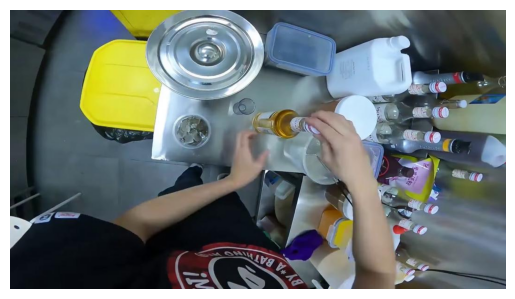

Procedure: Drop a glass on the countertop (success: None)
Q1: Is the glass on the countertop?
A1: Yes (0.855851)
Success probability 1: 0.796925

Coherence Metrics:
	Marginal Relevance (NLI): 0.953
	Marginal Relevance (VLM): 0.756687

	Marginal Informativeness (NLI): 0.852
	Marginal Informativeness (VLM): 0.271964

	Marginal Relevance x Marginal Informativeness (NLI): 0.8119559999999999
	Marginal Relevance x Marginal Informativeness (VLM): 0.205792


Q2: Is the glass broken?
A2: Yes (0.507812)
Success probability 2: 0.819893

Coherence Metrics:
	Marginal Relevance (NLI): 0.611
	Marginal Relevance (VLM): 0.042593

	Marginal Informativeness (NLI): 0.492
	Marginal Informativeness (VLM): 0.319689

	Marginal Relevance x Marginal Informativeness (NLI): 0.300612
	Marginal Relevance x Marginal Informativeness (VLM): 0.013617


Q3: Is the glass shattered?
A3: Yes (0.91611)
Success probability 3: 0.883236

Coherence Metrics:
	Marginal Relevance (NLI): 0.869
	Marginal Relevance (VLM): 0.321059

	

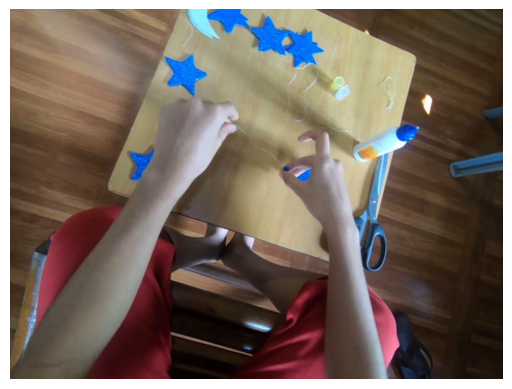

Procedure: Grab solder gun (mistake: MisalignSRL_V_ARG1)
Q1: Is the soldering iron in the person's hand?
A1: Yes (0.531209)
Success probability 1: 0.867036

Coherence Metrics:
	Marginal Relevance (NLI): 0.795
	Marginal Relevance (VLM): 0.830267

	Marginal Informativeness (NLI): 0.543
	Marginal Informativeness (VLM): 0.434489

	Marginal Relevance x Marginal Informativeness (NLI): 0.43168500000000004
	Marginal Relevance x Marginal Informativeness (VLM): 0.360742


Q2: Is the soldering iron in the person's right hand?
A2: Yes (0.675765)
Success probability 2: 0.932944

Coherence Metrics:
	Marginal Relevance (NLI): 0.832
	Marginal Relevance (VLM): 0.390081

	Marginal Informativeness (NLI): 0.649
	Marginal Informativeness (VLM): 0.64516

	Marginal Relevance x Marginal Informativeness (NLI): 0.539968
	Marginal Relevance x Marginal Informativeness (VLM): 0.251665


Q3: Is the person's right hand holding the soldering iron?
A3: Yes (0.996777)
Success probability 3: 0.965641

Coherence Metrics:

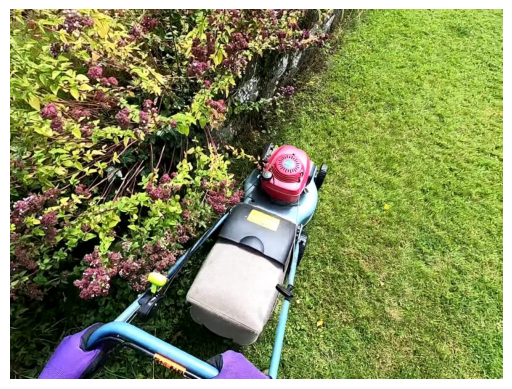

Procedure: Hold a screw (mistake: MisalignSRL_V_ARG1)
Q1: Is the person holding the screw?
A1: Yes (0.715424)
Success probability 1: 0.94699

Coherence Metrics:
	Marginal Relevance (NLI): 0.943
	Marginal Relevance (VLM): 0.895907

	Marginal Informativeness (NLI): 0.814
	Marginal Informativeness (VLM): 0.700952

	Marginal Relevance x Marginal Informativeness (NLI): 0.7676019999999999
	Marginal Relevance x Marginal Informativeness (VLM): 0.627988


Q2: Is the person holding the screw in their hand?
A2: Yes (0.83762)
Success probability 2: 0.96862

Coherence Metrics:
	Marginal Relevance (NLI): 0.948
	Marginal Relevance (VLM): 0.296288

	Marginal Informativeness (NLI): 0.829
	Marginal Informativeness (VLM): 0.798734

	Marginal Relevance x Marginal Informativeness (NLI): 0.7858919999999999
	Marginal Relevance x Marginal Informativeness (VLM): 0.236655


Q3: Is the screw in the person's hand?
A3: Yes (0.995245)
Success probability 3: 0.979823

Coherence Metrics:
	Marginal Relevance (NLI): 0.

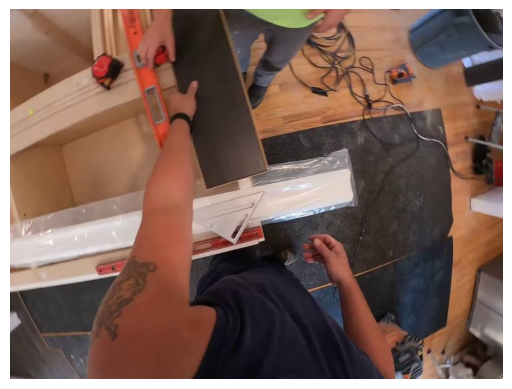

Procedure: Drop the phone charger on the ground (mistake: MisalignSRL_ARG1)
Q1: Is the phone charger on the ground?
A1: Yes (0.51562)
Success probability 1: 0.933431

Coherence Metrics:
	Marginal Relevance (NLI): 0.936
	Marginal Relevance (VLM): 0.896662

	Marginal Informativeness (NLI): 0.812
	Marginal Informativeness (VLM): 0.647013

	Marginal Relevance x Marginal Informativeness (NLI): 0.760032
	Marginal Relevance x Marginal Informativeness (VLM): 0.580152


Q2: Is the phone charger still connected to the phone?
A2: No (0.805632)
Success probability 2: 0.882428

Coherence Metrics:
	Marginal Relevance (NLI): 0.275
	Marginal Relevance (VLM): 0.040611

	Marginal Informativeness (NLI): 0.156
	Marginal Informativeness (VLM): 0.477659

	Marginal Relevance x Marginal Informativeness (NLI): 0.0429
	Marginal Relevance x Marginal Informativeness (VLM): 0.019398


Q3: Is the phone charger on the floor?
A3: Yes (0.984575)
Success probability 3: 0.923592

Coherence Metrics:
	Marginal Relevance (

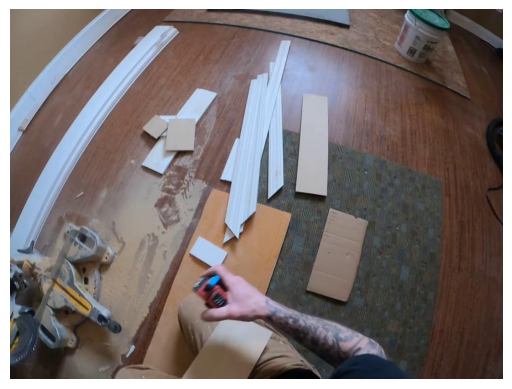

Procedure: Pick the measuring tape (success: None)
Q1: Is the person holding the measuring tape correctly?
A1: Yes (0.603932)
Success probability 1: 0.929951

Coherence Metrics:
	Marginal Relevance (NLI): 0.993
	Marginal Relevance (VLM): 0.876548

	Marginal Informativeness (NLI): 0.967
	Marginal Informativeness (VLM): 0.633894

	Marginal Relevance x Marginal Informativeness (NLI): 0.960231
	Marginal Relevance x Marginal Informativeness (VLM): 0.555638


Q2: Is the measuring tape in the correct position?
A2: Yes (0.79053)
Success probability 2: 0.963506

Coherence Metrics:
	Marginal Relevance (NLI): 0.893
	Marginal Relevance (VLM): 0.872124

	Marginal Informativeness (NLI): 0.733
	Marginal Informativeness (VLM): 0.77402

	Marginal Relevance x Marginal Informativeness (NLI): 0.654569
	Marginal Relevance x Marginal Informativeness (VLM): 0.675042


Q3: Is the measuring tape pointing in the right direction?
A3: Yes (0.92079)
Success probability 3: 0.969556

Coherence Metrics:
	Marginal Rel

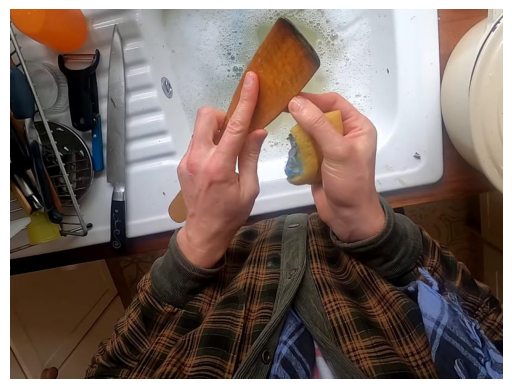

Procedure: Put sanitizer on the stool (mistake: MisalignSRL_V_ARG1)
Q1: Is the stool sanitized?
A1: Yes (0.665411)
Success probability 1: 0.990874

Coherence Metrics:
	Marginal Relevance (NLI): 0.999
	Marginal Relevance (VLM): 0.968588

	Marginal Informativeness (NLI): 0.995
	Marginal Informativeness (VLM): 0.925058

	Marginal Relevance x Marginal Informativeness (NLI): 0.994005
	Marginal Relevance x Marginal Informativeness (VLM): 0.896


Q2: Is the person wearing gloves?
A2: No (0.519521)
Success probability 2: 0.786623

Coherence Metrics:
	Marginal Relevance (NLI): 0.0
	Marginal Relevance (VLM): 0.20169

	Marginal Informativeness (NLI): 0.993
	Marginal Informativeness (VLM): 0.252112

	Marginal Relevance x Marginal Informativeness (NLI): 0.0
	Marginal Relevance x Marginal Informativeness (VLM): 0.050848


Q3: Is the stool clean?
A3: Yes (0.805632)
Success probability 3: 0.934873

Coherence Metrics:
	Marginal Relevance (NLI): 0.935
	Marginal Relevance (VLM): 0.323491

	Marginal Infor

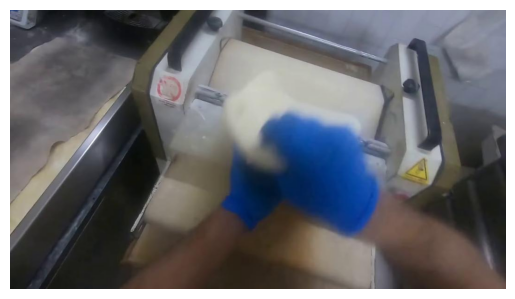

Procedure: Flatten the half of the dough with the dough flattener (success: None)
Q1: Has the dough flattener been used on the dough?
A1: Yes (0.90053)
Success probability 1: 0.978385

Coherence Metrics:
	Marginal Relevance (NLI): 0.997
	Marginal Relevance (VLM): 0.928796

	Marginal Informativeness (NLI): 0.984
	Marginal Informativeness (VLM): 0.849585

	Marginal Relevance x Marginal Informativeness (NLI): 0.981048
	Marginal Relevance x Marginal Informativeness (VLM): 0.789091


Q2: Is the dough flattened?
A2: Yes (0.817574)
Success probability 2: 0.997327

Coherence Metrics:
	Marginal Relevance (NLI): 0.975
	Marginal Relevance (VLM): 0.918117

	Marginal Informativeness (NLI): 0.91
	Marginal Informativeness (VLM): 0.973302

	Marginal Relevance x Marginal Informativeness (NLI): 0.88725
	Marginal Relevance x Marginal Informativeness (VLM): 0.893605


Q3: Is the dough flattened evenly?
A3: Yes (0.843895)
Success probability 3: 0.998522

Coherence Metrics:
	Marginal Relevance (NLI): 0.031


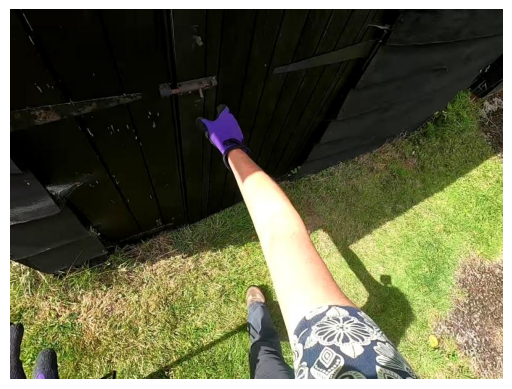

Procedure: Open the door (mistake: Action Incomplete)
Q1: Is the door open?
A1: No (0.689306)
Success probability 1: 0.00161

Coherence Metrics:
	Marginal Relevance (NLI): 0.992
	Marginal Relevance (VLM): 0.986521

	Marginal Informativeness (NLI): 0.966
	Marginal Informativeness (VLM): 0.98274

	Marginal Relevance x Marginal Informativeness (NLI): 0.958272
	Marginal Relevance x Marginal Informativeness (VLM): 0.969494


Q2: Is the door closed?
A2: Yes (0.538983)
Success probability 2: 0.001768

Coherence Metrics:
	Marginal Relevance (NLI): 0.142
	Marginal Relevance (VLM): 0.017356

	Marginal Informativeness (NLI): 0.282
	Marginal Informativeness (VLM): 0.981286

	Marginal Relevance x Marginal Informativeness (NLI): 0.04004399999999999
	Marginal Relevance x Marginal Informativeness (VLM): 0.017031


Q3: Is the person trying to open the door?
A3: Yes (0.987375)
Success probability 3: 0.001024

Coherence Metrics:
	Marginal Relevance (NLI): 0.097
	Marginal Relevance (VLM): 0.01103

	Margin

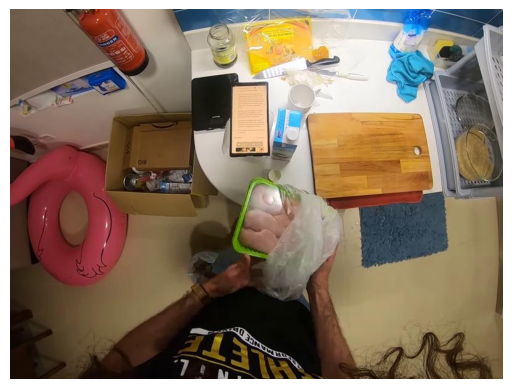

Procedure: Hold the pack of meat with your hand (mistake: Action Incomplete)
Q1: Is the person holding the pack of meat in their hand?
A1: Yes (0.91848)
Success probability 1: 0.980581

Coherence Metrics:
	Marginal Relevance (NLI): 0.959
	Marginal Relevance (VLM): 0.917792

	Marginal Informativeness (NLI): 0.864
	Marginal Informativeness (VLM): 0.861834

	Marginal Relevance x Marginal Informativeness (NLI): 0.828576
	Marginal Relevance x Marginal Informativeness (VLM): 0.790984


Q2: Is the pack of meat in the person's hand?
A2: Yes (0.993612)
Success probability 2: 0.993512

Coherence Metrics:
	Marginal Relevance (NLI): 0.981
	Marginal Relevance (VLM): 0.73668

	Marginal Informativeness (NLI): 0.923
	Marginal Informativeness (VLM): 0.943515

	Marginal Relevance x Marginal Informativeness (NLI): 0.905463
	Marginal Relevance x Marginal Informativeness (VLM): 0.695069


Q3: Is the person's hand holding the pack of meat?
A3: Yes (0.998633)
Success probability 3: 0.997065

Coherence Metric

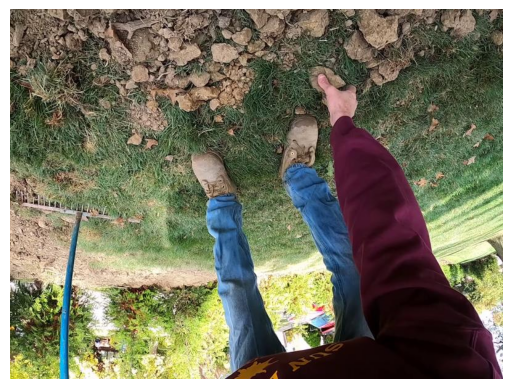

Procedure: Drop the box in the drawer with your hand (mistake: MisalignSRL_V_ARG1)
Q1: Is the box in the drawer?
A1: No (0.542863)
Success probability 1: 0.003538

Coherence Metrics:
	Marginal Relevance (NLI): 0.979
	Marginal Relevance (VLM): 0.971283

	Marginal Informativeness (NLI): 0.915
	Marginal Informativeness (VLM): 0.966095

	Marginal Relevance x Marginal Informativeness (NLI): 0.895785
	Marginal Relevance x Marginal Informativeness (VLM): 0.938352


Q2: Is the person's hand in the drawer?
A2: Yes (0.661923)
Success probability 2: 0.034881

Coherence Metrics:
	Marginal Relevance (NLI): 0.171
	Marginal Relevance (VLM): 0.02776

	Marginal Informativeness (NLI): 0.421
	Marginal Informativeness (VLM): 0.781692

	Marginal Relevance x Marginal Informativeness (NLI): 0.071991
	Marginal Relevance x Marginal Informativeness (VLM): 0.0217


Q3: Is the person's hand in the correct position to drop the box in the drawer?
A3: Yes (0.737158)
Success probability 3: 0.076961

Coherence Metrics

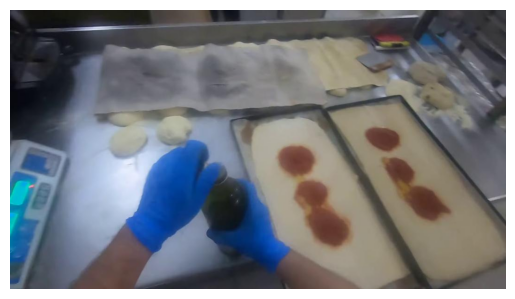

Procedure: Pour oil from the bottle to the dough in the tray (success: None)
Q1: Is the dough in the tray?
A1: Yes (0.971129)
Success probability 1: 0.667148

Coherence Metrics:
	Marginal Relevance (NLI): 0.798
	Marginal Relevance (VLM): 0.636004

	Marginal Informativeness (NLI): 0.537
	Marginal Informativeness (VLM): 0.082186

	Marginal Relevance x Marginal Informativeness (NLI): 0.4285260000000001
	Marginal Relevance x Marginal Informativeness (VLM): 0.052271


Q2: Is the dough in the tray ready to be cooked?
A2: Yes (0.870597)
Success probability 2: 0.860604

Coherence Metrics:
	Marginal Relevance (NLI): 0.663
	Marginal Relevance (VLM): 0.791062

	Marginal Informativeness (NLI): 0.347
	Marginal Informativeness (VLM): 0.417345

	Marginal Relevance x Marginal Informativeness (NLI): 0.230061
	Marginal Relevance x Marginal Informativeness (VLM): 0.330146


Q3: Is the dough in the tray cooked?
A3: No (0.978052)
Success probability 3: 0.63341

Coherence Metrics:
	Marginal Relevance (NLI):

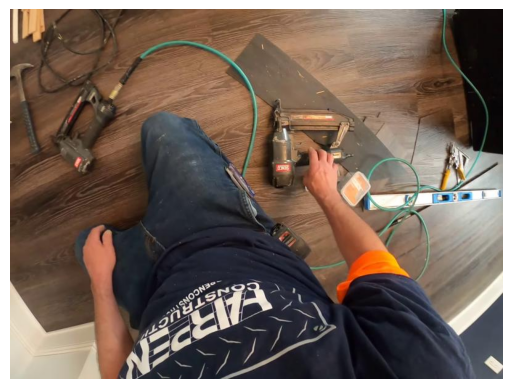

Procedure: Pick up the electric gun from the floor with your hand (mistake: Action Incomplete)
Q1: Is the person holding the electric gun in their hand?
A1: No (0.535098)
Success probability 1: 0.015544

Coherence Metrics:
	Marginal Relevance (NLI): 0.837
	Marginal Relevance (VLM): 0.960402

	Marginal Informativeness (NLI): 0.592
	Marginal Informativeness (VLM): 0.884369

	Marginal Relevance x Marginal Informativeness (NLI): 0.49550399999999994
	Marginal Relevance x Marginal Informativeness (VLM): 0.84935


Q2: Is the electric gun still on the floor?
A2: Yes (0.861538)
Success probability 2: 0.009413

Coherence Metrics:
	Marginal Relevance (NLI): 0.672
	Marginal Relevance (VLM): 0.054302

	Marginal Informativeness (NLI): 0.359
	Marginal Informativeness (VLM): 0.923124

	Marginal Relevance x Marginal Informativeness (NLI): 0.24124800000000002
	Marginal Relevance x Marginal Informativeness (VLM): 0.050127


Q3: Is the person standing over the electric gun?
A3: Yes (0.511717)
Success prob

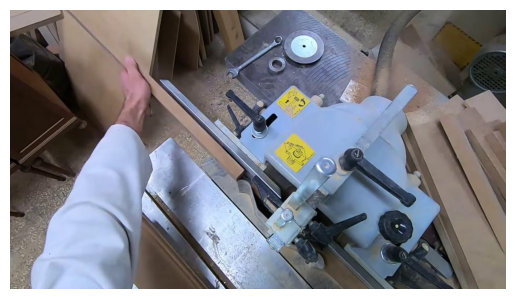

Procedure: Hold the fourth piece of wood with your hand (success: None)
Q1: Is the person holding the fourth piece of wood with their hand?
A1: Yes (0.61878)
Success probability 1: 0.985496

Coherence Metrics:
	Marginal Relevance (NLI): 0.976
	Marginal Relevance (VLM): 0.930491

	Marginal Informativeness (NLI): 0.907
	Marginal Informativeness (VLM): 0.890646

	Marginal Relevance x Marginal Informativeness (NLI): 0.885232
	Marginal Relevance x Marginal Informativeness (VLM): 0.828738


Q2: Is the person's hand holding the fourth piece of wood?
A2: Yes (0.969785)
Success probability 2: 0.994615

Coherence Metrics:
	Marginal Relevance (NLI): 0.954
	Marginal Relevance (VLM): 0.904522

	Marginal Informativeness (NLI): 0.854
	Marginal Informativeness (VLM): 0.951666

	Marginal Relevance x Marginal Informativeness (NLI): 0.814716
	Marginal Relevance x Marginal Informativeness (VLM): 0.860803


Q3: Is the person's hand holding the fourth piece of wood correctly?
A3: Yes (0.942507)
Success prob

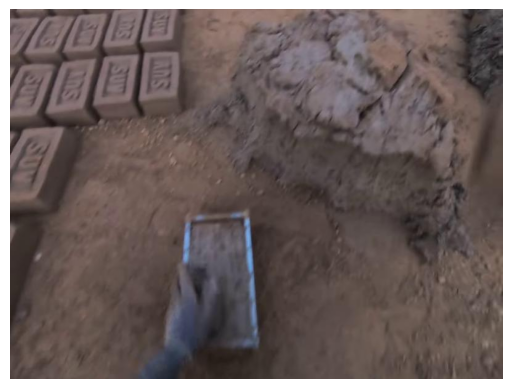

Procedure: Drop dough on the clothed tray (mistake: MisalignSRL_ARG1)
Q1: Is the dough on the tray?
A1: Yes (0.7773)
Success probability 1: 0.965641

Coherence Metrics:
	Marginal Relevance (NLI): 0.938
	Marginal Relevance (VLM): 0.940462

	Marginal Informativeness (NLI): 0.819
	Marginal Informativeness (VLM): 0.784198

	Marginal Relevance x Marginal Informativeness (NLI): 0.768222
	Marginal Relevance x Marginal Informativeness (VLM): 0.737509


Q2: Is the dough on the clothed tray?
A2: Yes (0.992539)
Success probability 2: 0.989347

Coherence Metrics:
	Marginal Relevance (NLI): 0.979
	Marginal Relevance (VLM): 0.80924

	Marginal Informativeness (NLI): 0.917
	Marginal Informativeness (VLM): 0.914908

	Marginal Relevance x Marginal Informativeness (NLI): 0.8977430000000001
	Marginal Relevance x Marginal Informativeness (VLM): 0.74038


Q3: Is the tray clothed?
A3: Yes (0.99486)
Success probability 3: 0.99341

Coherence Metrics:
	Marginal Relevance (NLI): 0.945
	Marginal Relevance (VLM): 

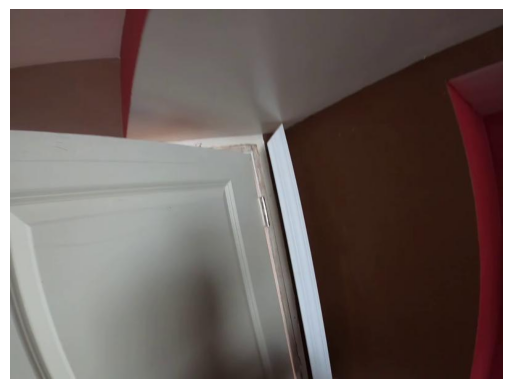

Procedure: Place the wood on the door frame (mistake: Action Incomplete)
Q1: Is the wood on the door frame?
A1: No (0.542863)
Success probability 1: 0.002823

Coherence Metrics:
	Marginal Relevance (NLI): 0.987
	Marginal Relevance (VLM): 0.983749

	Marginal Informativeness (NLI): 0.949
	Marginal Informativeness (VLM): 0.972026

	Marginal Relevance x Marginal Informativeness (NLI): 0.9366629999999999
	Marginal Relevance x Marginal Informativeness (VLM): 0.95623


Q2: Is the person working on the procedure to place the wood on the door frame?
A2: Yes (0.877477)
Success probability 2: 0.003765

Coherence Metrics:
	Marginal Relevance (NLI): 0.008
	Marginal Relevance (VLM): 0.002825

	Marginal Informativeness (NLI): 0.952
	Marginal Informativeness (VLM): 0.964258

	Marginal Relevance x Marginal Informativeness (NLI): 0.0076159999999999995
	Marginal Relevance x Marginal Informativeness (VLM): 0.002724


Q3: Is the person standing next to the door frame?
A3: Yes (0.891811)
Success probability

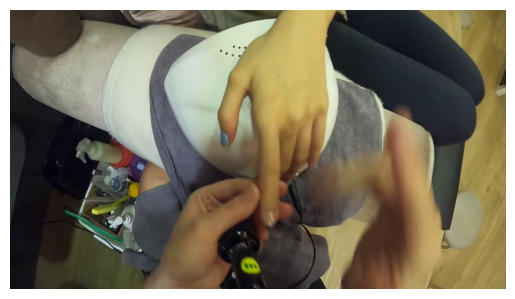

Procedure: Dip the nail polish brush in the nail polish bottle (success: None)
Q1: Is the nail polish brush in the bottle?
A1: Yes (0.715424)
Success probability 1: 0.936749

Coherence Metrics:
	Marginal Relevance (NLI): 0.974
	Marginal Relevance (VLM): 0.884904

	Marginal Informativeness (NLI): 0.898
	Marginal Informativeness (VLM): 0.659783

	Marginal Relevance x Marginal Informativeness (NLI): 0.874652
	Marginal Relevance x Marginal Informativeness (VLM): 0.583844


Q2: Is the nail polish brush dipped in the nail polish bottle?
A2: Yes (0.917303)
Success probability 2: 0.985828

Coherence Metrics:
	Marginal Relevance (NLI): 0.965
	Marginal Relevance (VLM): 0.961405

	Marginal Informativeness (NLI): 0.883
	Marginal Informativeness (VLM): 0.892672

	Marginal Relevance x Marginal Informativeness (NLI): 0.8520949999999999
	Marginal Relevance x Marginal Informativeness (VLM): 0.858219


Q3: Is the nail polish brush still in the bottle?
A3: Yes (0.562177)
Success probability 3: 0.985608



In [54]:
for output in random_outputs_to_visualize:
    
    frame_dir = os.path.join(output['frame_dir'], "frames")
    possible_frame_dirs = [frame_dir.replace("_debug250", f"_partition{i+1}of4") for i in range(4)]
    for pfd in possible_frame_dirs:
        try:
            frame_path = os.path.join(pfd, os.listdir(pfd)[0]) # only a single frame in frame dir
            frame = Image.open(frame_path)
            break
        except:
            continue
    plt.figure()
    plt.imshow(frame)
    plt.axis('off')
    plt.show()
    frame.close()

    print(f"Procedure: {output['procedure']} ({'mistake' if output['mistake'] else 'success'}: {output['mistake_type']})")
    for i in range(output['final_turn'] + 1):
        print(f"Q{i+1}: {output['questions'][i]}")
        print(f"A{i+1}: {'Yes' if output['answers'][i] == 1 else 'No'} ({output['answer_probs'][i][output['answers'][i]]})")
        print(f"Success probability {i+1}: {output['success_probs'][i]}")
        print("")
        print("Coherence Metrics:")
        print(f"\tMarginal Relevance (NLI): {output['coherence_nli']['relevance_marginal'][i]}")
        print(f"\tMarginal Relevance (VLM): {output['coherence_vlm']['relevance_marginal'][i]}")
        print("")
        print(f"\tMarginal Informativeness (NLI): {output['coherence_nli']['informativeness_marginal'][i]}")
        print(f"\tMarginal Informativeness (VLM): {output['coherence_vlm']['informativeness_marginal'][i]}")
        print("")
        print(f"\tMarginal Relevance x Marginal Informativeness (NLI): {output['coherence_nli']['informativeness_marginal_x_relevance_marginal'][i]}")
        print(f"\tMarginal Relevance x Marginal Informativeness (VLM): {output['coherence_vlm']['informativeness_marginal_x_relevance_marginal'][i]}")

        print("\n")
    
    print("\n\n\n")